# 3. laboratorijska vježba

In [1]:
# učitavanje potrebnih biblioteka

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

In [2]:
#@title pomoćna funkcija
# izvršite ovu ćeliju ali se ne opterećujte detaljima implementacije

def plot_frequency_response(f, Hm, fc=None, ylim_min=None):
    """Grafički prikaz prijenosne funkcije filtra.
    
    Args
        f (numpy.ndarray) : frekvencije
        Hm (numpy.ndarray) : apsolutne vrijednosti prijenosne funkcije
        fc (number) : cutoff frekvencija
        ylim_min (number): minimalna vrijednost na y-osi za dB skalu

    Returns
        (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot)
    """
    Hc = 1 / np.sqrt(2)
    if fc is None:
        fc_idx = np.where(np.isclose(Hm, Hc, rtol=1e-03))[0][0]
        fc = f[fc_idx]
    H_db = 20 * np.log10(Hm)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 7.5))

    ax[0, 0].plot(f, Hm, label='$H(f)$')
    ax[0, 0].plot(fc, Hc, 'o', label='$H(f_c)$')
    ax[0, 0].vlines(fc, Hm.min(), Hc, linestyle='--')
    ax[0, 0].annotate(f'$f_c = {fc:.3f}$ Hz\n$H(f_c)={Hc:.3f}$', (fc * 1.4, Hc))
    ax[0, 0].set_xscale('log')
    ax[0, 0].set_ylabel('$|V_{out}$ / $V_{in}$|')
    ax[0, 0].set_title('log scale')
    ax[0, 0].legend(loc='lower left')
    ax[0, 0].grid()
    
    ax[0, 1].plot(f, Hm, label='$H(f)$')
    ax[0, 1].plot(fc, Hc, 'o', label='$H(f_c)$')
    ax[0, 1].annotate(f'$f_c = {fc:.3f}$ Hz\n$H(f_c)={Hc:.3f}$', (fc * 1.4, Hc))
    ax[0, 1].set_title('linear scale')
    ax[0, 1].legend()
    ax[0, 1].grid()

    ax[1, 0].plot(f, H_db, label='$H_{dB}(f)$')
    ax[1, 0].plot(fc, H_db.max() - 3, 'o', label='$H_{dB}(f_c)$')
    ax[1, 0].vlines(fc, H_db.min(), H_db.max() - 3, linestyle='--')
    ax[1, 0].annotate(f'$f_c = {fc:.3f}$ Hz\n$H(f_c)={H_db.max() - 3:.3f} dB$',
                      (fc * 1.4, H_db.max() - 3))
    ax[1, 0].set_xscale('log')
    ax[1, 0].set_xlabel('$f$ [Hz]')
    ax[1, 0].set_ylabel('$20 \\cdot \\log$ |$V_{out}$ / $V_{in}$|')
    if ylim_min:
        ax[1, 0].set_ylim((ylim_min, 10))
    ax[1, 0].legend(loc='lower left')
    ax[1, 0].grid()

    ax[1, 1].plot(f, H_db, label='$H_{dB}(f)$')
    ax[1, 1].plot(fc, H_db.max() - 3, 'o', label='$H_{dB}(f_c)$')
    ax[1, 1].annotate(f'$f_c = {fc:.3f}$ Hz\n$H(f_c)={H_db.max() - 3:.3f} dB$',
                      (fc * 1.4, H_db.max() - 3))
    ax[1, 1].set_xlabel('$f$ [Hz]')
    if ylim_min:
        ax[1, 1].set_ylim((ylim_min, 10))
    ax[1, 1].legend()
    ax[1, 1].grid()

    fig.tight_layout
    return fig, ax

### Pasivni visoko-propusni filtri

Realizacija visoko-propusnog filtra u ovom slučaju se ostvaruje korištenjem otpornika i zavojnice povezanih u seriju, pri čemu se izlaz promatra kao napon na zavojnici, $V_{out}$ Uz pretpostavku da je signal na ulazu, $V_{in}$, sinusoidalni naponski izvor, analizu možemo prebaciti u frekvencijsku domenu koristeći impedancijski model. Na ovaj način izbjegavamo potrebu za korištenjem diferencijalnog računa i čitav proračun se svodi na jednostavni algebarski problem. 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Series-RL.svg/768px-Series-RL.svg.png" alt="simple-rl-highpass" width="400"/>
</center>

Izraz za funkciju prijenosnog odziva dobijamo kao omjer izlaznog i ulaznog napona. Izlazni napon - napon na zavojnici, $V_{out}$, definiramo kroz podjelu ulaznog napona na sljedeći način:

$$
\begin{align}
    V_{out} &= \frac{Z_l}{Z_l + Z_r} \cdot V_{in} \\
    H(\omega) = \frac{V_{out}}{V_{in}} &= \frac{Z_l}{Z_l + Z_r} = \frac{j\omega L}{j\omega L + R} = \frac{1}{1+R/(j\omega L)}
\end{align}
$$

Kako je $H$ funkcija frekvencije, imamo dva ruba slučaja:
* za iznimno niske frekvencije kada je $\omega \sim 0$ slijedi da je $H(\omega) \rightarrow 0$;
* za iznimno visoke frekvencije kada $\omega \rightarrow \infty$ slijedi da je $H(\omega) = 0$.

Potrebno je dodatno definirati već spomenutu *cut-off* frekvenciju, $f_c$, za koju amplituda funkcije frekvencijskog odziva, $H$, pada za $\sqrt 2$ puta, odnosno za $3$ dB:
$$
\begin{align}
    f_c &= \frac{R}{2 \pi L}
\end{align}
$$

Link za interaktivni rad sa pasivnim visoko-propusnim filtrom: http://sim.okawa-denshi.jp/en/LRtool.php

#### Zadatak 1

Prvi zadatak je implementirati funkciju `cutoff_frequency` koja na ulazu prima iznose otpora, `R`, i zavojnice, `L`, a na izlazu daje *cutoff* frekvenciju visoko-propusnog filtra.

In [3]:
def cutoff_frequency(R, L):
    """Cutoff frekvencija nisko-propusnog filtra.
    
    Args:
        R (number) : vrijednost otpora otpornika
        L (number) : induktivitet zavojnice
    
    Returns:
        number
    """
    #######################################################
    ## TO-DO: implementiraj proračun cutoff frekvencije ##
    # Nakon toga zakomentiraj sljedeću liniju.
    # raise NotImplementedError('Implementiraj proračun cutoff frekvencije.')
    #######################################################

    # definiraj cutoff frekvenciju
    fc = R / (2 * np.pi * L)
    return fc

Kolika je *cutoff* frekvencija za otpor od $200 \Omega$ i induktivitet zavojnice od $100 mH$?

In [4]:
R = 200  # otpor
L = 100e-3  # induktivitet

fc = cutoff_frequency(R, L)  # cutoff frekvencija

print(f'R = {R/1000} kΩ')
print(f'L = {L*1000} mH')
print(f'cutoff frekvencija iznosi {fc:.2f} Hz, '
      'očekivana vrijednost je 318.31 Hz')

R = 0.2 kΩ
L = 100.0 mH
cutoff frekvencija iznosi 318.31 Hz, očekivana vrijednost je 318.31 Hz


#### Zadatak 2

Drugi zadatak je implementirati funkciju `rl_highpass` koja na ulazu prima iznose otpora, `R`, induktiviteta, `L`, i frekvenciju, `f`, a na izlazu daje prijenosni odziv pasivnog visoko-propusnog RL filtra.

In [5]:
def rl_highpass(R, L, f):
    """Funkcija prijenosnog odziva RC nisko-propusnog filtra.
    
    Args:
        R (number) : vrijednost otpora otpornika
        L (number) : induktivitet
        f (number or numpy.ndarray) : frekvencija/e
    
    Returns:
        float or numpy.ndarray
    """
    ######################################################
    ## TO-DO: implementiraj funkciju prijenosnog odziva ##
    # Nakon toga zakomentiraj sljedeću liniju.
    # raise NotImplementedError('Implementiraj funckiju prijenosnog odziva.')
    ######################################################

    # definiraj funkciju prijenosnog pazeći da `f` može biti ili broj (int,
    # float) ili 1-D niz (`numpy.ndarray`)
    H = 1 / (1 + 1 / (1.0j * 2 * np.pi * f * L / R)) 
    return H

Kolika je vrijednost prijenosne funkcije pri *cutoff* frekvencija za otpor od $200 \Omega$ i induktivitet zavojnice od $100 mH$?

In [6]:
R = 200  # otpor
L = 100e-3  # induktivitet

Hc = rl_highpass(R, L, fc)  # prijenosna funkcija pri cutoff frekvenciji

print(f'R = {R:.2f} Ω')
print(f'C = {L * 1000:.2f} mH')
print(f'pojačanje pri cutoff frekvenciji iznosi {abs(Hc):.4f}, '
      'očekivana vrijednost je 1/√2\n\n'
      'provjerite ispravnost dobivenog rezutltata')

R = 200.00 Ω
C = 100.00 mH
pojačanje pri cutoff frekvenciji iznosi 0.7071, očekivana vrijednost je 1/√2

provjerite ispravnost dobivenog rezutltata


In [7]:
# ćelija za provjeru rezultata



Pretvorite vrijednost prijenosne funkcije pri *cutoff* frekvenciju u decibele i uvjerite se u tvrdnju da amplituda funkcije frekvencijskog odziva, $H$, pada za $3$ dB pri *cutoff* frekvenciji.

In [8]:
Hc_dB = 20 * np.log10(abs(Hc))  # pretvorba prijenosne funkcije pri cutoff frekvenciji u dB skalu
print(Hc_dB)

-3.0102999566398116


Za raspon od $10000$ vrijednosti frekvencija do $10 kHz$ te za otpor od $200 \Omega$ i induktivitet zavojnice od $100 mH$, izračunajte vrijednosti prijenosne funkcije.

In [10]:
f = np.linspace(0.01, 10000, num=10000)
H = rl_highpass(R, L, f)  # prijenosna funkcija

S obzirom da su vrijednosti prijenosne funkcije kompleksne veličine, razmilite što je potrebno napraviti s njima prije nego ih grafički prikažemo?

In [11]:
Hm = np.abs(H) # konverzija u apsolutne vrijednosti

Vizualizirajte ovisnost prijenosne funkcije o frekvenciji koristeći `matplotlib` i funkciju `matplotlib.pyplot.plot`.

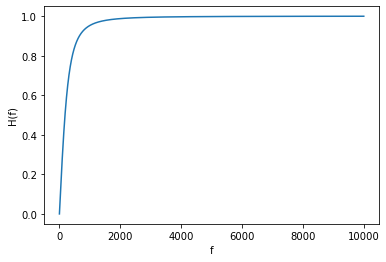

In [12]:
plt.plot(f, Hm)
plt.xlabel('f')
plt.ylabel('H(f)')
plt.show()

Vizualizirajte sada rezultate koristeći već implementiranu funkciju `plot_frequency_response`.

Napomena: za provjeru načina korištenja prethodne funkcije koristite sljedeću naredbu:

```python
help(plot_frequency_response)
```

ili jednostavno

```python
plot_frequency_response?
```

In [13]:
# provjerite način korištenja funkcije

plot_frequency_response?

Signature: plot_frequency_response(f, Hm, fc=None, ylim_min=None)
Docstring:
Grafički prikaz prijenosne funkcije filtra.

Args
    f (numpy.ndarray) : frekvencije
    Hm (numpy.ndarray) : apsolutne vrijednosti prijenosne funkcije
    fc (number) : cutoff frekvencija
    ylim_min (number): minimalna vrijednost na y-osi za dB skalu

Returns
    (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot)
File:      ~/github/teaching/emc_512/lab/Python/<ipython-input-2-3f92c444d500>
Type:      function


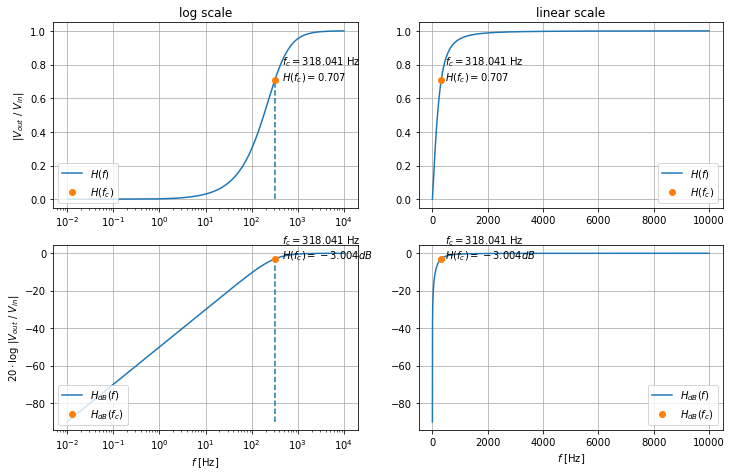

In [14]:
fig, ax = plot_frequency_response(f, Hm)  # grafički prikaz dobivenih rezultata

### Strujno-naponska karakteristika RL visoko-propusnog filtra

In [19]:
def time_constant(L, R):
    return L / R

In [20]:
def rl_current(t, t_switch, V, R, L):
    I0 = V / R
    i = np.where(t < t_switch,
                 I0 * (1 - np.exp((-R / L) * t)),
                 I0 * np.exp((-R / L) * (t - t_switch)))
    return i

In [33]:
V = 5
tau = time_constant(L, R)
t_switch = tau * 4.4
T = 2 * t_switch
t = np.linspace(0, T)
i_rl = rl_current(t, t_switch, V, R, L)
i = V / R * np.sin(2 * np.pi * t / T)

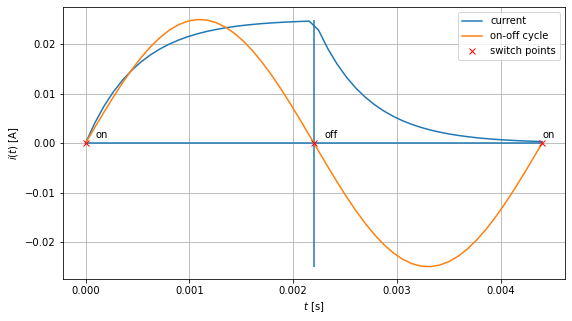

In [34]:
plt.figure(figsize=(9, 5))
plt.plot(t, i_rl, label='current')
plt.plot(t, i, label='on-off cycle')
plt.plot([t.min(), switch_time, t.max()], [0, 0, 0], 'rx', label='switch points')
plt.text(t.min() + 1e-4, I.min() + 1e-3, 'on')
plt.text(switch_time + 1e-4, I.min() + 1e-3, 'off')
plt.text(t.max(), I.min() + 1e-3, 'on')
plt.hlines(0, t.min(), t.max())
plt.vlines(switch_time, i.min(), i.max())
plt.xlabel('$t$ [s]')
plt.ylabel('$i(t)$ [A]')
plt.legend()
plt.grid()
plt.show()

### Pojasno propusni filtri
Sljedeći kod koristi više različitih tipova pojasno-propusnih filtara (Hamming, Kaiser, Remez) i uspoređuje ih s idealnom prijenosnom funkcijom.

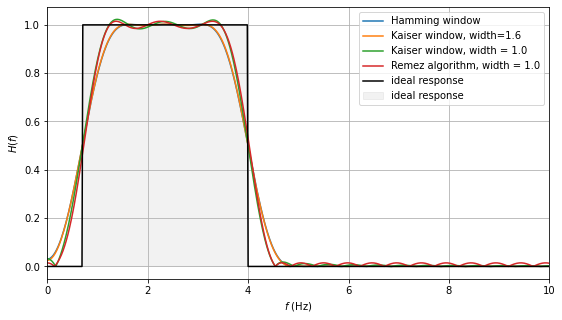

In [6]:
def bandpass_firwin(ntaps, lowcut, highcut, fs, window='hamming'):
    nyq = 0.5 * fs
    taps = ss.firwin(ntaps, [lowcut, highcut], nyq=nyq, pass_zero=False, window=window, scale=False)
    return taps


def bandpass_kaiser(ntaps, lowcut, highcut, fs, width):
    nyq = 0.5 * fs
    atten = ss.kaiser_atten(ntaps, width / nyq)
    beta = ss.kaiser_beta(atten)
    taps = ss.firwin(ntaps, [lowcut, highcut], nyq=nyq, pass_zero=False, window=('kaiser', beta), scale=False)
    return taps

def bandpass_remez(ntaps, lowcut, highcut, fs, width):
    delta = 0.5 * width
    edges = [0, lowcut - delta, lowcut + delta, highcut - delta, highcut + delta, 0.5*fs]
    taps = ss.remez(ntaps, edges, [0, 1, 0], Hz=fs)
    return taps


fs = 63.0
lowcut = 0.7
highcut = 4.0

ntaps = 128
taps_hamming = bandpass_firwin(ntaps, lowcut, highcut, fs=fs)
taps_kaiser16 = bandpass_kaiser(ntaps, lowcut, highcut, fs=fs, width=1.6)
taps_kaiser10 = bandpass_kaiser(ntaps, lowcut, highcut, fs=fs, width=1.0)
remez_width = 1.0
taps_remez = bandpass_remez(ntaps, lowcut, highcut, fs=fs, width=remez_width)

plt.figure(figsize=(9, 5))
w, h = ss.freqz(taps_hamming, 1, worN=2000)
plt.plot(fs*0.5/np.pi*w, np.abs(h), label="Hamming window")

w, h = ss.freqz(taps_kaiser16, 1, worN=2000)
plt.plot(fs*0.5/np.pi*w, np.abs(h), label='Kaiser window, width=1.6')

w, h = ss.freqz(taps_kaiser10, 1, worN=2000)
plt.plot(fs*0.5/np.pi*w, np.abs(h), label='Kaiser window, width = 1.0')

w, h = ss.freqz(taps_remez, 1, worN=2000)
plt.plot(fs*0.5/np.pi*w, np.abs(h), label=f'Remez algorithm, width = {remez_width}')

h = np.where((fs*0.5/np.pi*w < lowcut) | (fs*0.5/np.pi*w > highcut), 0, 1)
plt.plot(fs*0.5/np.pi*w, h, 'k-', label='ideal response')
plt.fill_between(fs*0.5/np.pi*w, h, color='gray', alpha=0.1, label='ideal response')

plt.xlim(0, 10.0)
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('$f$ (Hz)')
plt.ylabel('$H(f)$')
plt.show()